# DEMO

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT
from torchvision.utils import save_image, make_grid
from torchvision import transforms, datasets
import torch.nn.functional as F

# VQ-VAE

In [3]:
from models.vqvae import VQVAEModel

# Creamos y cargamos el modelo VQ-VAE
vqvae = VQVAEModel(ndim=3, hidden_size=516, k=256, beta=0.25, device='cpu', lr=0.001)
vqvae.load('./checkpoint/vqvae_checkpoint')

Modelo Cargado


In [4]:
# Cargamos la data
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = datasets.CIFAR10('data',
                train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('data',
    train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=64, shuffle=False,
    pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 74620705.55it/s]


Extracting data/cifar-10-python.tar.gz to data


## Imagenes Originales

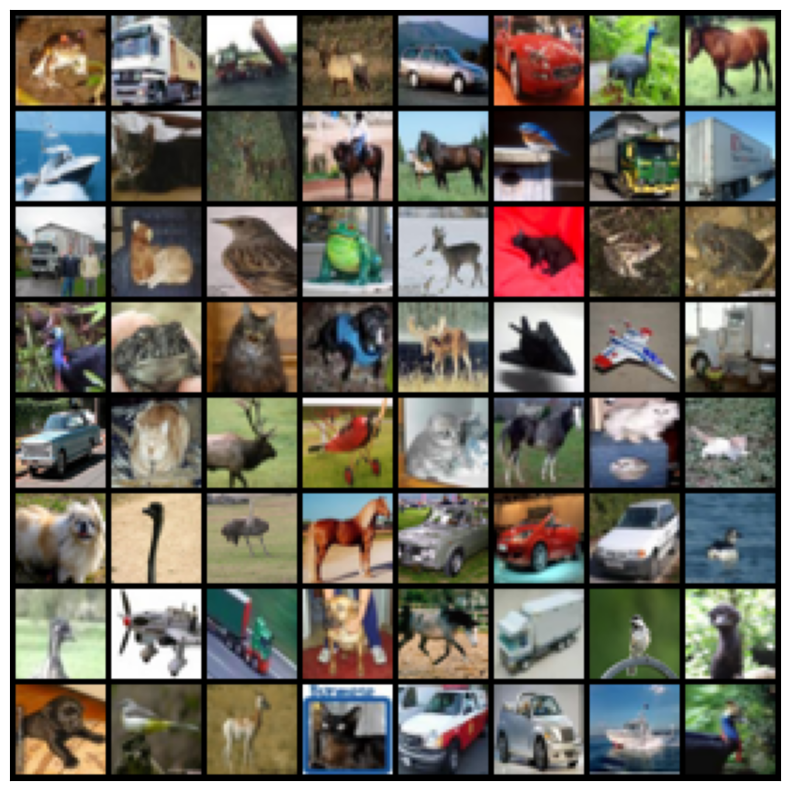

In [5]:
example, labels = next(iter(train_loader))
grid = make_grid(example, nrow=8, normalize=True)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FT.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(grid)

## Reconstrucción

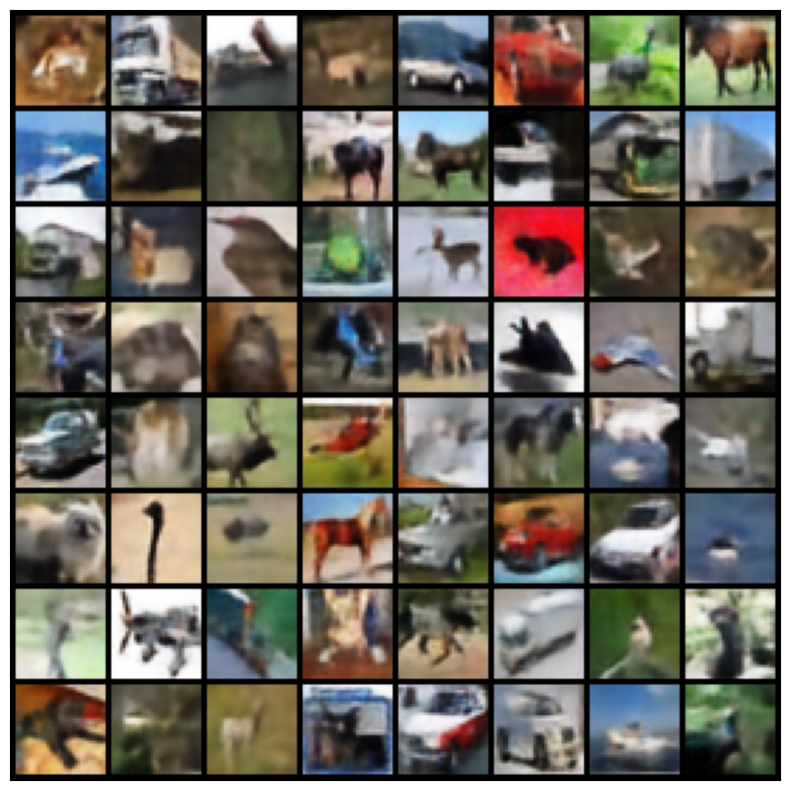

In [6]:
def generate_samples(images, model):
    with torch.no_grad():
        images = images
        x_tilde, _, _ = model(images)
    return x_tilde

reconstruction = generate_samples(example, vqvae.model)
grid = make_grid(reconstruction.cpu(), nrow=8, normalize=True)
show(grid)

# RoundTrip

In [7]:
from models.roundtrip import RoundtripModel, Generator_, Discriminator_

class Gaussian_sampler(object):
    def __init__(self, mean, sd=1, N=10000):
        self.total_size = N
        self.mean = mean
        self.sd = sd
        self.X = np.random.normal(self.mean, self.sd, (self.total_size,len(self.mean)))
        self.Y = None

    def train(self, batch_size, label = False):
        indx = np.random.randint(low = 0, high = self.total_size, size = batch_size)
        return self.X[indx, :]

    def get_batch(self,batch_size):
        return np.random.normal(self.mean, self.sd, (batch_size,len(self.mean)))

    def load_all(self):
        return self.X, self.Y

n_epochs = 500
n_classes = 10
latent_space = 128
batch_size = 4096

dx = latent_space + n_classes
dy = 516 * 8 * 8
alpha = 10
beta = 10

g_net = Generator_(latent_dim = dx, out_shape= dy, n_layers=10, n_units=512)
h_net = Generator_(latent_dim= dy, out_shape = dx, n_layers=10, n_units=256)
dx_net = Discriminator_(inp_shape = dx, n_layers=2, n_units=128)
dy_net = Discriminator_(inp_shape = dy, n_layers=4, n_units=256)

x_sampler = Gaussian_sampler(mean=np.zeros(latent_space), sd=1.0)

prior = RoundtripModel(vqvae.model, x_sampler, g_net, h_net, dx_net, dy_net, alpha, beta, batch_size, 'cpu')
prior.load('./checkpoint')

Modelo Cargado


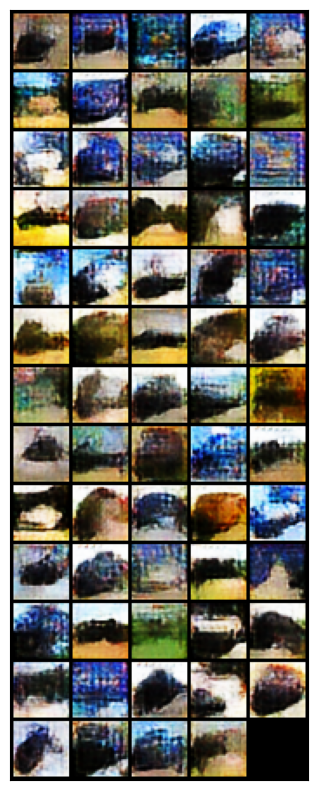

In [8]:
img = prior.predict_y(F.one_hot(labels))[0]
img = vqvae.model.decoder(img)
grid = make_grid(img, nrow=5, normalize=True)

show(grid)

# PixelCNN

In [9]:
from models.pixelcnn import PixelCNNModel

In [10]:
prior = PixelCNNModel(256, 10, 'cpu', 0.001)
prior.load('./checkpoint/pixelcnn_prior')

Modelo Cargado


In [11]:
imgs = None
for clase in range(10):
    z = prior.model.generate(label=torch.Tensor([clase]).long(), batch_size=5)
    if imgs is None:
        imgs = z
    else:
        imgs = torch.cat((imgs, z), 0)

imgs = vqvae.model.decode(imgs)

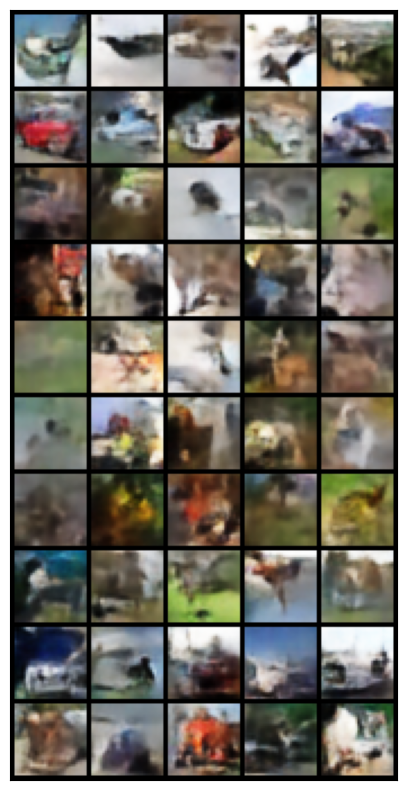

In [12]:
grid = make_grid(imgs, nrow=5, normalize=True)

show(grid)